In [16]:
#%% importing packages
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

from numpy import percentile
import matplotlib.pyplot as plt
import matplotlib.font_manager
import seaborn as sns

# Import all models
from sklearn.neighbors import LocalOutlierFactor
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve

In [17]:
#%%import data sets
X_train = pd.read_csv("C:\\Users\\jenny\\Desktop\\springboard\\capstone1\\feature\\scaled_X_train.csv").iloc[:,1:]
y_train = pd.read_csv("C:\\Users\\jenny\\Desktop\\springboard\\capstone1\\feature\\y_train.csv").iloc[:,1:]
X_test = pd.read_csv("C:\\Users\\jenny\\Desktop\\springboard\\capstone1\\feature\\scaled_X_test.csv").iloc[:,1:]
y_test = pd.read_csv("C:\\Users\\jenny\\Desktop\\springboard\\capstone1\\feature\\y_test.csv").iloc[:,1:]

x = X_train.drop(['weapon','user','ranking'],axis=1)
x_test = X_test.drop(['weapon','user','ranking'],axis=1)

In [18]:
#%% KMeans Classification
param_grid = {'n_neighbors':np.arange(1,50)}
knn = KNeighborsRegressor()
knn_cv= GridSearchCV(knn,param_grid,cv=5)
knn_cv.fit(x, y_train)

GridSearchCV(cv=5, estimator=KNeighborsRegressor(),
             param_grid={'n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49])})

In [19]:
print("The best R-squared score: "+str(knn_cv.best_score_))
#this is really poor,

The best R-squared score: 0.10551776727241642


In [20]:
#%% Outlier Detection
# fit the model for outlier detection make a grid search for parameters
holder = pd.DataFrame({'lof' : [0]*990})
for nn in range(10,1000):
    clf = LocalOutlierFactor(n_neighbors=nn, contamination=0.1)
    y_pred = clf.fit_predict(x,y_train)
    holder.iloc[(nn-10),0] = np.max(abs(clf.negative_outlier_factor_))

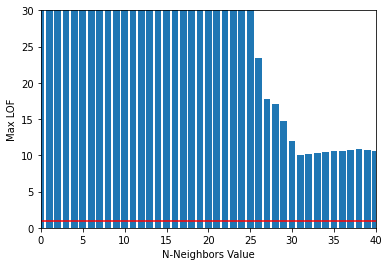

<Figure size 432x288 with 0 Axes>

In [35]:
#%% Plotting the LOF across all the nearest neighbors
hindex = pd.DataFrame({'i':holder.index})
plt.ylim([0,30])
plt.xlim(0,40)
plt.bar(x=hindex.loc[:,'i'],height=holder.loc[:,'lof'])
plt.xlabel("N-Neighbors Value")
plt.ylabel("Max LOF")
plt.axhline(y=1, color='r', linestyle='-')
plt.show()
plt.savefig('max_lof_plt.png')

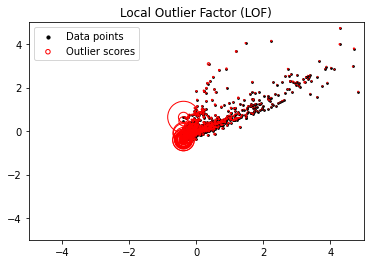

In [38]:
#%%looks like 31 neighbors is the best solution
clf_final = LocalOutlierFactor(n_neighbors=31, contamination=0.1)
y_pred = clf_final.fit_predict(x,y_train)
lof = abs(clf_final.negative_outlier_factor_)
X_scores = clf_final.negative_outlier_factor_

plt.title("Local Outlier Factor (LOF)")
plt.scatter(x.iloc[:, 0], x.iloc[:, 1], color='k', s=3., label='Data points')
# plot circles with radius proportional to the outlier scores
radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())
plt.scatter(x.iloc[:, 0], x.iloc[:, 1], s=1000 * radius, edgecolors='r', facecolors='none', label='Outlier scores')
plt.axis('tight')
plt.xlim((-5, 5))
plt.ylim((-5, 5))
legend = plt.legend(loc='upper left')
legend.legendHandles[0]._sizes = [10]
legend.legendHandles[1]._sizes = [20]
plt.show()

In [39]:
#%%making it into a category variable for the Kmeans
cat_lof = np.zeros((x.shape[0],1))
for i in range(0,x.shape[0]):
    if lof[i] > 1.5:
        cat_lof[i,0]=1
param_grid = {'n_neighbors':np.arange(1,10)}
knn = KNeighborsClassifier()
knn_cv= GridSearchCV(knn,param_grid,cv=5)
knn_cv.fit(x, np.ravel(cat_lof))
#getting the best based on the grid search
print("Best Score:" + str(knn_cv.best_score_))
print("Best Parameters: " + str(knn_cv.best_params_))

Best Score:0.9586080586080585
Best Parameters: {'n_neighbors': 1}


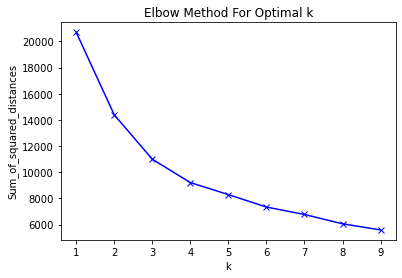

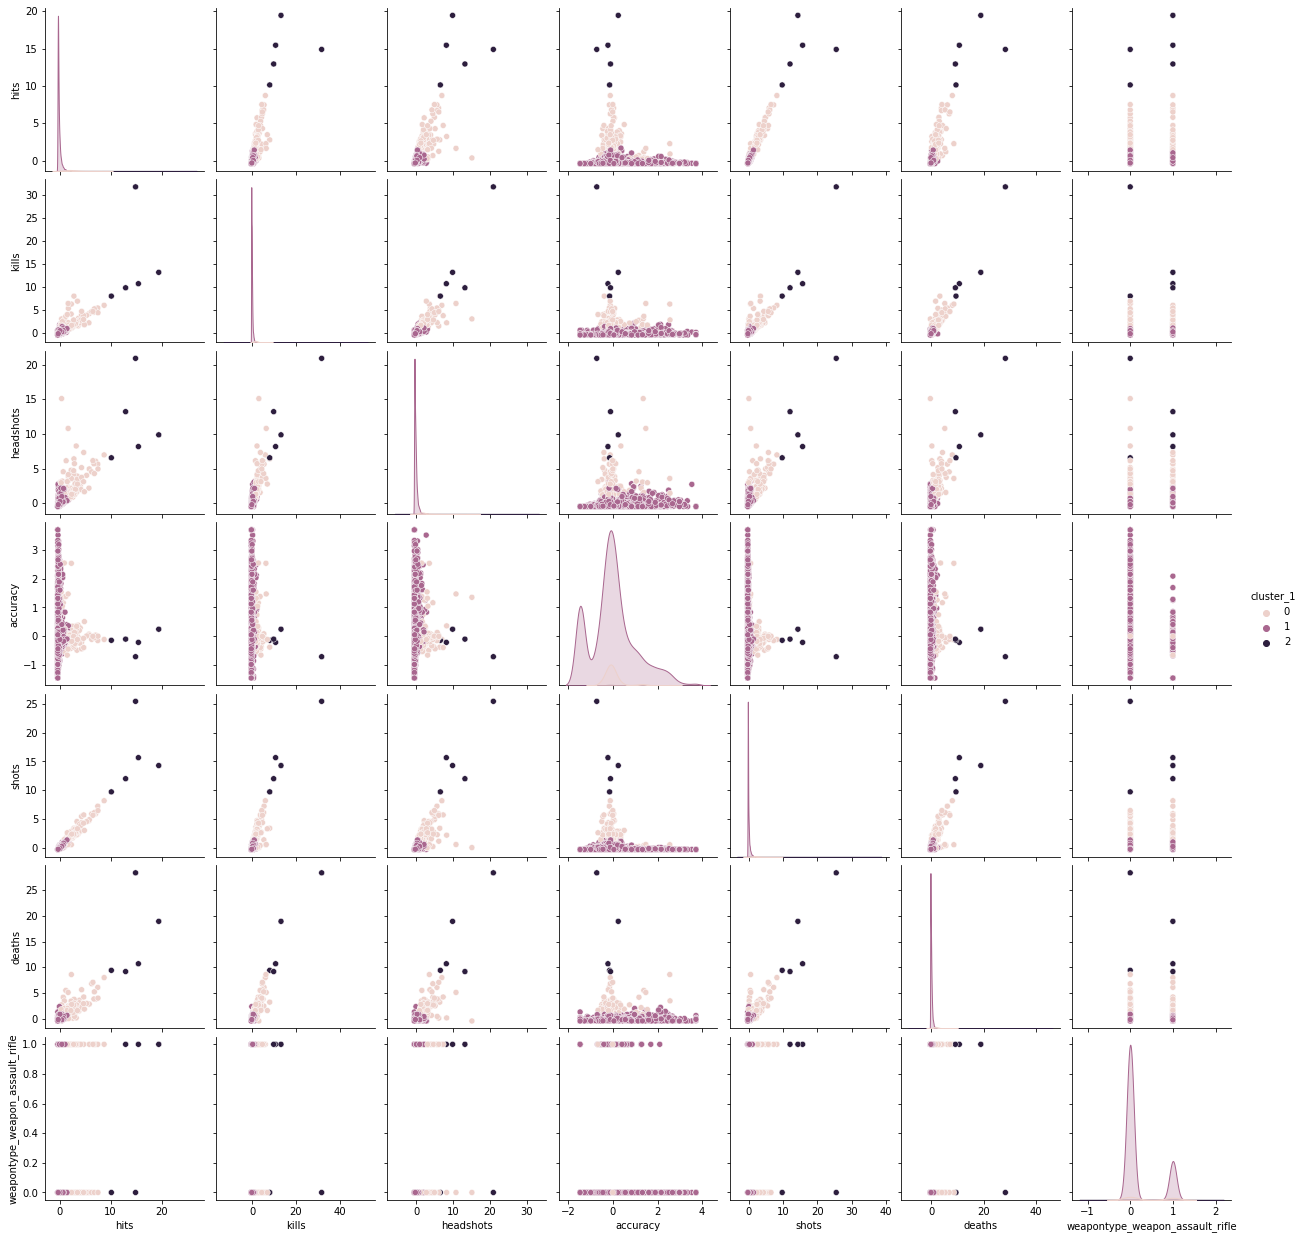

In [25]:
#%% doing kmeans to get the elbow plot
Sum_of_squared_distances = []
from sklearn.cluster import KMeans
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(x,np.ravel(cat_lof))
    Sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()
#based on this I will go with two clusters here a plot of the clusters
km = KMeans(n_clusters=3)
distances_1 = km.fit_transform(x,np.ravel(cat_lof))
labels_1 = km.labels_
x['cluster_1']=labels_1
with sns.color_palette("hls", 8):
    sns.pairplot(x.iloc[:,[0,1,2,3,4,5,6,19]], hue='cluster_1')

In [40]:
#do the bagging after the grid search with the classification being the outliers in the training data set. Then make predictions with the testing data set
x_no_cluster = x.drop(['cluster_1'],axis=1)
clf = BaggingClassifier(base_estimator=KMeans(n_clusters=2), n_estimators=20, random_state=0).fit(x_no_cluster,np.ravel(cat_lof))
y_pred = clf.predict(x_test)